# Hälsostudie
- **För VG:** Motivera dina metodval i markdown och hänvisa till dokumentation eller annan källa.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Förhandsgranska data

Vi vill förhandsgranska våra data för att få en första förståelse av hur datasetet ser ut och om det finns eventuella problem.
Genom att använda df.head(), df.describe() och df.info() kan vi se exempel på observationer, få en statistisk sammanfattning samt information om datatyper och antal värden.
Med df.isna().sum() undersöker vi dessutom om det finns saknade värden som kan behöva hanteras innan vidare analys.

In [2]:
# Öppnar och läser filen
df = pd.read_csv("health_study_dataset.csv")

# Förhandsgranskar datan
display(df.head())
display(df.describe())
display(df.info())

df.isna().sum()

,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0
1,2,47,M,180.4,95.9,144.8,5.18,Yes,0
2,3,59,F,169.9,82.2,151.7,6.16,No,0
3,4,72,M,157.7,93.1,151.0,6.63,No,0
4,5,46,M,192.6,104.1,144.1,5.21,No,0


,id,age,height,weight,systolic_bp,cholesterol,disease
count,800.0000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,400.5000,49.426250,171.849250,73.413000,149.178625,4.929150,0.058750
std,231.0844,14.501118,9.804259,13.685059,12.793360,0.848413,0.235303
min,1.0000,18.000000,144.400000,33.700000,106.800000,2.500000,0.000000
25%,200.7500,39.000000,164.775000,64.800000,140.900000,4.327500,0.000000
50%,400.5000,50.000000,171.350000,73.200000,149.400000,4.970000,0.000000
75%,600.2500,59.000000,178.925000,82.600000,157.600000,5.482500,0.000000
max,800.0000,90.000000,200.400000,114.400000,185.900000,7.880000,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB


None

id             0
age            0
sex            0
height         0
weight         0
systolic_bp    0
cholesterol    0
smoker         0
disease        0
dtype: int64

## Beskrivande analys

Vi vill undersöka våra data genom en beskrivande analys för att få en överblick över centrala mått och fördelningar.
Vi vill därför räkna ut medelvärde, median, minimum och maximum för variablerna age, weight, height, systolic_bp och cholesterol.
Dessutom vill vi visualisera resultaten genom tre olika grafer som ger en översikt över rökning, blodtryck och vikt hos populationen från datasetet. 

### Översikt - Statistik för hälsodata

In [3]:
# Tar fram statistik för hälsodata
columns = ["age", "weight", "height", "systolic_bp", "cholesterol"]
data = df[columns]

statistics = pd.DataFrame({
    "Medel": data.mean(),
    "Median": data.median(),
    "Min": data.min(),
    "Max": data.max()
}).round(2)

statistics.style \
    .set_caption("<h2> Översikt - Statistik för hälsodata") \
    .format("{:.2f}")

,Medel,Median,Min,Max
age,49.43,50.00,18.00,90.00
weight,73.41,73.20,33.70,114.40
height,171.85,171.35,144.40,200.40
systolic_bp,149.18,149.40,106.80,185.90
cholesterol,4.93,4.97,2.50,7.88


### Hälsostudie: Översikt över rökning, blodtryck och vikt

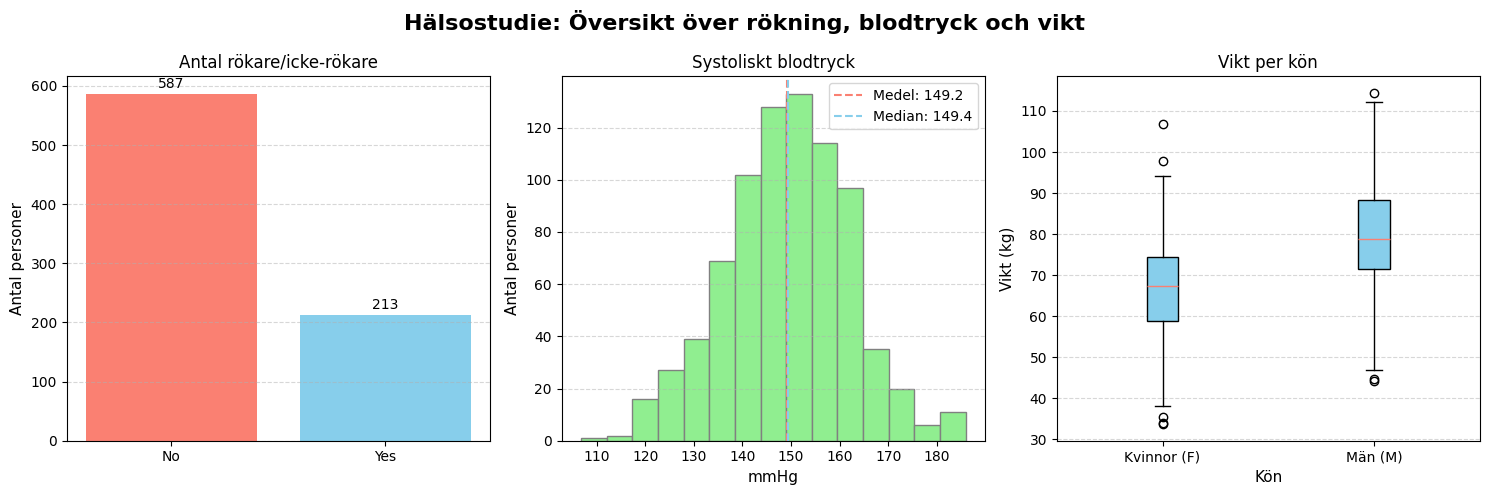

In [14]:
# SKAPAR FIGUR MED 1 RAD OCH 3 KOLUMNER (GRAFER)
# ========================
figs, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=False)

# SUBPLOT 1: Bar chart för rökare
# ========================
ax1 = axes[0]
counts = df["smoker"].value_counts()
bars = ax1.bar(counts.index, counts.values, color=['salmon', 'skyblue'])

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 5, str(int(height)),
             ha='center', va='bottom', fontsize=10)

ax1.set_title("Antal rökare/icke-rökare", fontsize=12)
ax1.set_ylabel("Antal personer", fontsize=11)
ax1.grid(True, axis="y", linestyle="--", alpha=0.5)
ax1.tick_params(axis='x')

# SUBPLOT 2: Histogram systoliskt blodtryck
# ========================
ax2 = axes[1]
ax2.hist(df["systolic_bp"], bins=15, color="lightgreen", edgecolor="grey")

mean_bp = df["systolic_bp"].mean()
median_bp = df["systolic_bp"].median()

ax2.axvline(mean_bp, color='salmon', linestyle='dashed', linewidth=1.5, label=f'Medel: {mean_bp:.1f}')
ax2.axvline(median_bp, color='skyblue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_bp:.1f}')

ax2.set_title("Systoliskt blodtryck", fontsize=12)
ax2.set_xlabel("mmHg", fontsize=11)
ax2.set_ylabel("Antal personer", fontsize=11)
ax2.grid(True, axis="y", linestyle="--", alpha=0.5)
ax2.legend()

# SUBPLOT 3: Boxplot över vikt per kön
# ========================
ax3 = axes[2]
ax3.boxplot(
    [df.loc[df['sex'] == 'F', 'weight'], df.loc[df['sex'] == 'M', 'weight']],
    tick_labels=["Kvinnor (F)", "Män (M)"],
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='black'),
    medianprops=dict(color='salmon', linewidth=1)
)

ax3.set_title("Vikt per kön", fontsize=12)
ax3.set_xlabel("Kön", fontsize=11)
ax3.set_ylabel("Vikt (kg)", fontsize=11)
ax3.grid(True, axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Hälsostudie: Översikt över rökning, blodtryck och vikt", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Individer med sjukdomen

Vi vill undersöka andelen personer i vårt dataset som har sjukdomen.
Vi vill därför simulera 1000 slumpmässigt valda personer med samma sannolikhet för sjukdom med hjälp av NumPy.
Slutligen vill vi jämföra den simulerade andelen med den verkliga andelen i datasetet för att se hur väl simuleringen stämmer överens med "verkligheten".

### Andel personer med och utan sjukdomen

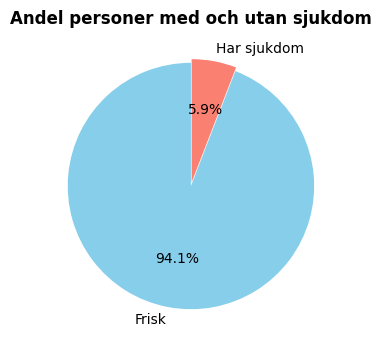

In [ ]:
# SKAPAR ETT CIRKELDIAGRAM ÖVER PERSONER MED SJUKDOMEN
# ========================
disease_counts = df["disease"].value_counts().sort_index()

plt.figure(figsize=(3, 3))
plt.pie(
    disease_counts.values,
    labels=["Frisk", "Har sjukdom"],
    autopct="%1.1f%%",
    colors=["skyblue", "salmon"],
    startangle=90,
    explode=(0, 0.03)
)
plt.title("Andel personer med och utan sjukdom", fontsize=12, fontweight='bold')
plt.show()

### Sanolikheten att insjukna

Vi vill ta reda på hur väl en slumpmässig simulering av 1000 personer (baserad på den observerade sannolikheten för sjukdom) stämmer överens med den verkliga andelen i datasetet.

In [6]:
# Simulerar sannolikheten för sjukdomen - jämför med den verkliga andelen i datasetet

# 1. Verklig andel 
# ========================
disease_part = df["disease"].value_counts()
true_proportion = disease_part[1] / disease_part.sum()
print(f"Andelen med sjukdomen: {true_proportion:.1%}")

# 2. Simulera 1000 personer med samma sannolikhet
# ========================
np.random.seed(42)                                  # ger samma slump varje gång man testkör - vill jag hga med det?
simulated_disease = np.random.choice(
    [0, 1],                                         # möjliga värden (0=frisk, 1=sjuk)
    size=1000,                                      # antal personer
    p=[1 - true_proportion, true_proportion]        # sannolikheterna blir tillsammans 1 eftersom en persone är sjuk eller inte sjuk 
)

# 3. Beräkna den simulerande andelen
# ========================
simulated_proportion = simulated_disease.mean()     # fungerar eftersom medelvärdet av 0/1 motsvarar proportionen av 1:or.
print(f"Andelen med sjukdomen i simuleringen: {simulated_proportion:.1%}")

# 4. Jämför verklig och simulerad andel
# ========================
print("=====================================")
print(f"Verklig andel:     {true_proportion:.1%}")
print(f"Simulerad andel:   {simulated_proportion:.1%}")
print(f"Skillnad:          {abs(simulated_proportion - true_proportion):.2%}")


Andelen med sjukdomen: 5.9%
Andelen med sjukdomen i simuleringen: 5.6%
Verklig andel:     5.9%
Simulerad andel:   5.6%
Skillnad:          0.27%


## Konfidensintervall

Vi vill undersöka medelvärdet av systoliskt blodtryck i vårt stickprov och hur osäkert detta estimat är.
Vi vill därför beräkna ett 95 % konfidensintervall för det sanna medelvärdet i populationen.
För att göra detta använder vi metoderna normalapproximation och bootstrap och jämför resultaten. 

In [ ]:
# Beräkning av konfidensintervall för medelvärdet av systolic_bp (sbp)

# Normalapproximation
# ========================
pop_sbp = df["systolic_bp"].dropna()
n = len(pop_sbp)
mean_sbp = pop_sbp.mean()
std_sbp = pop_sbp.std(ddof=1)                # stickprovsstandardavvikelse

# Standardfel (SE = s / sqrt(n)) (= osäkerheten i medelvärde)
se_sbp = std_sbp / np.sqrt(n)

# Beräkna 95 % konfidensintervall med normalapproximation
z = 1.96
ci_lower_sbp = mean_sbp - z * se_sbp
ci_upper_sbp = mean_sbp + z * se_sbp

print(f"Punktestimat (medelvärde):    {mean_sbp:.1f} mmHg")
print(f"Standardfel:                  {se_sbp:.3f} mmHg")
print("=====================================")
print(f"95% konfidensintervall med normalapproximation:       [{ci_lower_sbp:.1f}, {ci_upper_sbp:.1f}] mmHg")

# Bootstrap
# ========================
n_boot = 10_000
boot_means = []

# Kör bootstrap-loop
for i in range(n_boot):
    sample_sbp = np.random.choice(pop_sbp, size=n, replace=True)
    boot_means.append(sample_sbp.mean())
# Konverterar till array
boot_means = np.array(boot_means)

# Beräkna 95 % konfidensintervall med bootstrap
ci_lower_boot = np.percentile(boot_means, 2.5)
ci_upper_boot = np.percentile(boot_means, 97.5)

print("=====================================")
print(f"95% konfidensintervall med bootstrap:                 [{ci_lower_boot:.1f}, {ci_upper_boot:.1f}] mmHg")


Punktestimat (medelvärde):    149.2 mmHg
Standardfel:                  0.452 mmHg
95% konfidensintervall med normalapproximation:       [148.3, 150.1] mmHg
95% konfidensintervall med Bootstrap:                 [148.3, 150.1] mmHg


## Hypotesprövning

- Testa hypotesen: ”Rökare har högre medel-blodtryck än icke-rökare.”
- Använd en av metoderna vi gått igenom (t.ex. bootstrap eller enkel t-test-funktion).
- Förklara kort resultatet i en markdown-ruta.
- **För VG**: Gör en simulering för att undersöka hur säkert ditt hypotes­test är (t.ex. hur ofta testet hittar en skillnad när den finns → power).